In [1]:
%cd ../..

/volatile/home/Zaccharie/workspace/understanding-unets


In [2]:
# this just to make sure we are using only on CPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [3]:
%matplotlib nbagg
import glob
import os.path as op
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage.transform import resize
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm_notebook

from fastmri_recon.config import *
from fastmri_recon.data.data_utils import from_file_to_kspace
from fastmri_recon.helpers.fourier import fft, ifft
from fastmri_recon.helpers.nn_mri import tf_fastmri_format
from fastmri_recon.helpers.utils import gen_mask, normalize_instance, crop_center, gen_mask_tf
from learning_wavelets.keras_utils.fourier import (
    tf_masked_shifted_normed_fft2d, tf_masked_shifted_normed_ifft2d,
    tf_shifted_normed_fft2d, tf_shifted_normed_ifft2d)
from learning_wavelets.models.ista import IstaLearnlet

In [4]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['image.cmap'] = 'gray'

In [5]:
spades = rgb2gray(mpimg.imread('experiments/ista_learnlets/bird.jpg'))
# spades = spades[200:1000, :]
spade_size = 64
spades = resize(spades, (spade_size, spade_size), anti_aliasing=True)
plt.figure()
plt.imshow(spades)

<IPython.core.display.Javascript object>

In [6]:
# paths
val_path = f'{FASTMRI_DATA_DIR}singlecoil_val/'
filenames = glob.glob(val_path + '*.h5')
af = 4
kspace = from_file_to_kspace(filenames[150]) * 1e6
selected_slice = 15
kspace = kspace[selected_slice]
image = ifft(kspace).astype(kspace.dtype)
image[332:332 + spade_size, 132:132 + spade_size] *= spades
plt.figure()
plt.imshow(crop_center(np.abs(image), 320))

<IPython.core.display.Javascript object>

In [7]:
learnlet_params = {
    'denoising_activation': 'dynamic_soft_thresholding',
    'learnlet_analysis_kwargs':{
        'n_tiling': 16, 
        'mixing_details': False,    
        'skip_connection': True,
        'kernel_size': 7,
    },
    'learnlet_synthesis_kwargs': {
        'res': True,
        'kernel_size': 9,
    },
    'threshold_kwargs':{
        'noise_std_norm': False,
        'alpha_init': 2.0,
    },
    'n_scales': 4,
    'n_reweights_learn': 1,
    'exact_reconstruction': True,
    'undecimated': True,
    'clip': False,
}

model = IstaLearnlet(
    n_iterations=5,
    forward_operator=tf_masked_shifted_normed_fft2d,
    adjoint_operator=tf_masked_shifted_normed_ifft2d,
    postprocess=tf_fastmri_format,
    fista_mode=True,
    **learnlet_params,
)
model([tf.zeros((1, 640, 320, 1), dtype=tf.complex64), tf.zeros((1, 640, 320), dtype=tf.complex64)])
model.load_weights(
    'checkpoints/fista_learnlet_fastmri_16_5_dynamic_soft_thresholding_1583847877-300.hdf5',
)

In [8]:
image = tf.convert_to_tensor(image[None, ...])
mask = gen_mask_tf(image, af)

In [9]:
# # learnlets
# with tf.GradientTape() as tape:
#     tape.watch(image)
#     kspace_spades = tf_masked_shifted_normed_fft2d(image, mask)
#     kspace_mask_spades = (kspace_spades[..., None], mask)
#     res = model(kspace_mask_spades)
#     image_fastmri = tf_fastmri_format(image[..., None])
#     loss = tf.nn.l2_loss(res - image_fastmri)
# gradient = tape.gradient(loss, image)
# signed_grad = tf.sign(gradient)

# epsilon = 1
# kspace_adv = tf_masked_shifted_normed_fft2d(image + epsilon * signed_grad, mask)
# kspace_mask_adv = (kspace_adv[..., None], mask)
# res_adv = model(kspace_mask_adv)

In [10]:
# fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
# axs[0, 0].imshow(crop_center(np.abs(image[0]), 320), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))
# axs[0, 1].imshow(np.abs(res[0, ..., 0]), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))
# axs[1, 0].imshow(crop_center(np.abs(image[0] + epsilon * signed_grad[0]), 320), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))
# axs[1, 1].imshow(np.abs(res_adv[0, ..., 0]), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))

In [11]:
# from fastmri_recon.models.cascading import cascade_net

# run_params = {
#     'n_cascade': 5,
#     'n_convs': 5,
#     'n_filters': 48,
#     'noiseless': True,
# }

# cascade_model = cascade_net(**run_params)
# cascade_model.load_weights('/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/checkpoints/cascadenet_af4_1568926824-300.hdf5')

In [12]:
# # cascade net
# with tf.GradientTape() as tape:
#     tape.watch(image)
#     kspace_spades = tf_masked_shifted_normed_fft2d(image, mask)
#     kspace_mask_spades = (kspace_spades[..., None], mask)
#     res = cascade_model(kspace_mask_spades)
#     image_fastmri = tf_fastmri_format(image[..., None])
#     loss = tf.nn.l2_loss(res - image_fastmri)
# gradient = tape.gradient(loss, image)
# signed_grad = tf.sign(gradient)

# epsilon = 1
# kspace_adv = tf_masked_shifted_normed_fft2d(image + epsilon * signed_grad, mask)
# kspace_mask_adv = (kspace_adv[..., None], mask)
# res_adv = cascade_model(kspace_mask_adv)

In [13]:
# fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
# axs[0, 0].imshow(crop_center(np.abs(image[0]), 320), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))
# axs[0, 1].imshow(np.abs(res[0, ..., 0]), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))
# axs[1, 0].imshow(crop_center(np.abs(image[0] + epsilon * signed_grad[0]), 320), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))
# axs[1, 1].imshow(np.abs(res_adv[0, ..., 0]), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))

In [25]:
learnlet_params = {
    'denoising_activation': 'dynamic_soft_thresholding',
    'learnlet_analysis_kwargs':{
        'coarse': True,
    },
    'learnlet_synthesis_kwargs': {
        'res': True,
    },
    'threshold_kwargs':{
        'noise_std_norm': False,
        'alpha_init': 5.5*1e-5,
    },
    'n_scales': 4,
    'exact_reconstruction': False,
    'wav_only': True,
    'undecimated': False,
    'clip': False,
}

classical_model = IstaLearnlet(
    n_iterations=200,
    forward_operator=tf_masked_shifted_normed_fft2d,
    adjoint_operator=tf_masked_shifted_normed_ifft2d,
    postprocess=tf_fastmri_format,
    fista_mode=True,
    **learnlet_params,
)

classical_model([tf.zeros((1, 640, 320, 1), dtype=tf.complex64), tf.zeros((1, 640, 320), dtype=tf.complex64)]);

In [26]:
%%time
# cascade net
with tf.GradientTape() as tape:
    tape.watch(image)
    kspace_spades = tf_masked_shifted_normed_fft2d(image, mask)
    kspace_mask_spades = (kspace_spades[..., None], mask)
    res = classical_model(kspace_mask_spades)
    image_fastmri = tf_fastmri_format(image[..., None])
    loss = tf.nn.l2_loss(res - image_fastmri)
gradient = tape.gradient(loss, image)
signed_grad = tf.sign(gradient)

CPU times: user 16min 10s, sys: 1min 16s, total: 17min 27s
Wall time: 10min 39s


In [34]:
epsilon = 10
kspace_adv = tf_masked_shifted_normed_fft2d(image + epsilon * signed_grad, mask)
kspace_mask_adv = (kspace_adv[..., None], mask)
res_adv = classical_model(kspace_mask_adv)

<IPython.core.display.Javascript object>


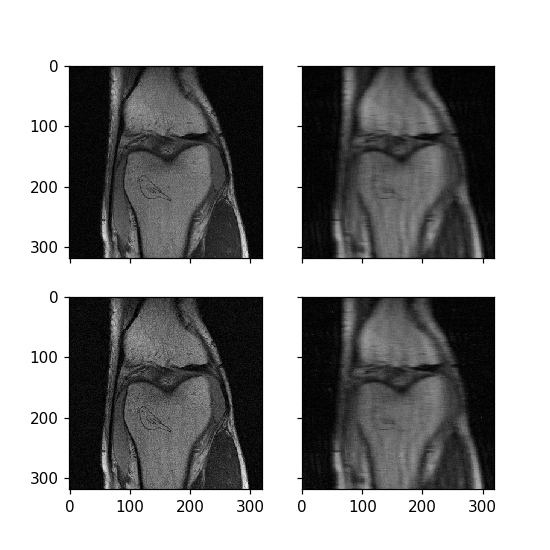

In [35]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
axs[0, 0].imshow(crop_center(np.abs(image[0]), 320), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))
axs[0, 1].imshow(np.abs(res[0, ..., 0]), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))
axs[1, 0].imshow(crop_center(np.abs(image[0] + epsilon * signed_grad[0]), 320), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))
axs[1, 1].imshow(np.abs(res_adv[0, ..., 0]), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))